In [3]:
!pip install nselib

In [4]:
import pandas as pd
import datetime

import nselib
from nselib import capital_market

In [5]:
def getSingleStock(symbol, start_date=None, end_date=None, keep_only_col: str=None, series: str=None, period: str=None):
  params = {}
  if period is None and (start_date is None and end_date is None):
    print("Error: Please set the period OR (start_date, end_date).")
  elif period is None and (start_date is None or end_date is None):
    print("Error: Please set start_date and end_date). Else set period.")
  elif period is None and (start_date is not None or end_date is not None):
    params['from_date'] = start_date.strftime('%d-%m-%Y')
    params['to_date'] = end_date.strftime('%d-%m-%Y')
    print(end_date.strftime('%d-%m-%Y'))
  elif period is not None and (start_date is None and end_date is None):
    if period not in ['1W', '1M', '6M', '1Y']:
      print("Error: Set period to one of the following accepted value: ('1W', '1M', '6M', '1Y')")
    params['period'] = period
  else:
    print("Error: Please provide either `start_date` and `end_date` OR provide `period` values correctly.")

  if series == 'EQTY':
    params['symbol'] = symbol
    df = capital_market.price_volume_data(**params)
  elif series == 'INDX':
    params['index'] = symbol
    df = capital_market.index_data(**params)
    df.rename({'INDEX_NAME': 'Symbol',
               'OPEN_INDEX_VAL': 'OpenPrice',
               'CLOSE_INDEX_VAL': 'ClosePrice',
               'HIGH_INDEX_VAL': 'HighPrice',
               'LOW_INDEX_VAL': 'LowPrice',
               'TRADED_QTY': 'TotalTradedQuantity',
               'TURN_OVER': 'Turnover',
               'TIMESTAMP': 'Date',
               },
              axis='columns',
              inplace=True)
  else:
    print("Error: Please set series value correctly.")

  df['OpenPrice'] = pd.to_numeric(df['OpenPrice'].replace({",":""}, regex=True))
  df['ClosePrice'] = pd.to_numeric(df['ClosePrice'].replace({",":""}, regex=True))
  df['HighPrice'] = pd.to_numeric(df['HighPrice'].replace({",":""}, regex=True))
  df['LowPrice'] = pd.to_numeric(df['LowPrice'].replace({",":""}, regex=True))

  df['SYMBOL'] = symbol
  df['DATE'] = pd.to_datetime(df['Date'], dayfirst=True)
  #  Make the dates the frame's index
  df.set_index('DATE', inplace = True)
  df = df.sort_index()
  if keep_only_col is not None:
    if keep_only_col not in list(df.columns):
      print(f"Error: {keep_only_col} is NOT a valid column name of the fetched data. Please check.")
    #  Rename the Close columns.  This is convenient when we build our new frames as the column names have to be unique
    df = df.rename(columns = {keep_only_col: symbol})
  return df

def getMultipleStock(scripts, start_date=None, end_date=None, period: str= None, keep_only_col: str=None, ):
  stocks = {i: [] for i in scripts}
  for stock, series in scripts.items():
    try:
      stocks[stock] = getSingleStock(symbol=stock, start_date=start_date, end_date=end_date, keep_only_col=keep_only_col, series=series, period=period)
    except:
      print('Problem with getting data')
    try:
      print(stock, len(stocks[stock].index))
    except:
      pass

  if keep_only_col is not None:
    #  Select our date range
    date_index_min = min([df_i.index.min() for df_i in stocks.values()])
    date_index_max = max([df_i.index.max() for df_i in stocks.values()])
    date_range = pd.date_range(date_index_min, date_index_max)
    df = pd.DataFrame(index = date_range)
    for k, v in stocks.items():
      df = df.join(v[k], how = 'inner')
    # Return the Dataframe with only the provided columns of individual script
    return df
  else:
    # Return full data dictionary
    return stocks


# start_date = datetime.date(2024, 1, 31)
# end_date = datetime.date(2024, 6, 1)
# scripts = {
#     'NIFTY 50': 'INDX',
#     'HINDOILEXP': 'EQTY',
#     'JKPAPER': 'EQTY'
#     }
# df = getMultipleStock(scripts, start_date=start_date, end_date=end_date, keep_only_col='ClosePrice')
# df = getMultipleStock(scripts, period='1M', keep_only_col='ClosePrice')
# print(len(df.index))


In [6]:
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date.today()
stock_name = 'HINDOILEXP'
scripts = {
    stock_name: 'EQTY',
    }
df = getMultipleStock(scripts, start_date=start_date, end_date=end_date, keep_only_col='ClosePrice')
# df = getMultipleStock(scripts, period='1Y', keep_only_col='ClosePrice')
print(len(df.index))

## If you want to read from a a csv file:
# df = pd.read_csv('AAPL.csv')

24-07-2024
HINDOILEXP 3627
3627


In [26]:
df

,HINDOILEXP
2010-01-04,304.00
2010-01-05,304.00
2010-01-06,295.80
2010-01-07,296.85
2010-01-08,298.10
...,...
2024-07-18,247.77
2024-07-19,242.30
2024-07-22,236.79
2024-07-23,241.68


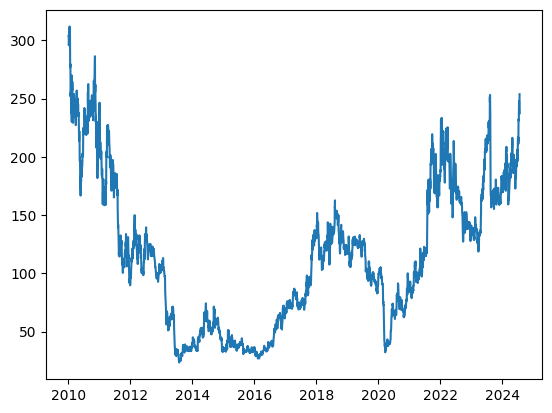

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df[stock_name])

# **Now Training and Prediction**

In [73]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [24]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  if type(first_date_str) == type(""):
    first_date = str_to_datetime(first_date_str)
  else:
    first_date = first_date_str
  if type(first_date_str) == type(""):
    last_date  = str_to_datetime(last_date_str)
  else:
      last_date = last_date_str

  values = dataframe.loc[first_date: last_date].to_numpy()

  dates = []
  X, Y = [], []

  l = len(values)
  count = n
  while count < l:
    x, y = values[count - n: count], values[count][0]
    dates.append(dataframe.index[count])
    X.append(x)
    Y.append(y)
    count += 1

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

In [44]:
# The training and prediction will be based on n previous values.
n = 4

windowed_df = df_to_windowed_df(df,
                                df.index.min(),
                                df.index.max(),
                                n=n)
windowed_df

,Target Date,Target-4,Target-3,Target-2,Target-1,Target
0,2010-01-08,304.00,304.00,295.80,296.85,298.10
1,2010-01-11,304.00,295.80,296.85,298.10,299.90
2,2010-01-12,295.80,296.85,298.10,299.90,306.95
3,2010-01-13,296.85,298.10,299.90,306.95,310.45
4,2010-01-14,298.10,299.90,306.95,310.45,305.35
...,...,...,...,...,...,...
3618,2024-07-18,224.56,232.17,231.15,236.63,247.77
3619,2024-07-19,232.17,231.15,236.63,247.77,242.30
3620,2024-07-22,231.15,236.63,247.77,242.30,236.79
3621,2024-07-23,236.63,247.77,242.30,236.79,241.68


In [42]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((3623,), (3623, 4, 1), (3623,))

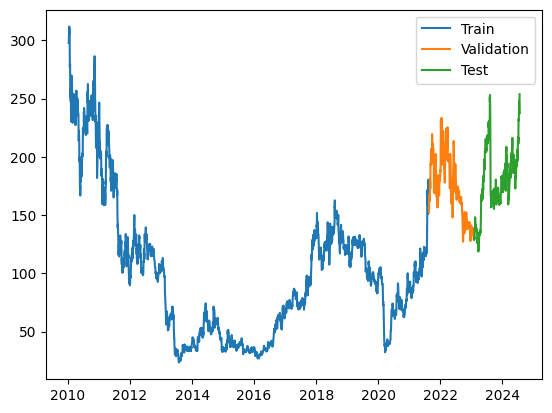

In [45]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((n, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
91/91 [==============================] - 4s 14ms/step - loss: 10492.8555 - mean_absolute_error: 82.5690 - val_loss: 11351.0215 - val_mean_absolute_error: 102.9473
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 2020.7186 - mean_absolute_error: 27.6686 - val_loss: 243.1590 - val_mean_absolute_error: 11.4984
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 99.0088 - mean_absolute_error: 4.2883 - val_loss: 97.4147 - val_mean_absolute_error: 7.9223
Epoch 4/100
91/91 [==============================] - 1s 9ms/step - loss: 32.8797 - mean_absolute_error: 3.1743 - val_loss: 48.9178 - val_mean_absolute_error: 5.4608
Epoch 5/100
91/91 [==============================] - 1s 9ms/step - loss: 25.7746 - mean_absolute_error: 2.9883 - val_loss: 40.7316 - val_mean_absolute_error: 4.4466
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 22.8643 - mean_absolute_error: 2.9814 - val_loss: 47.8187 - val_mean_absolute_error: 5.

91/91 [==============================] - 1s 2ms/step


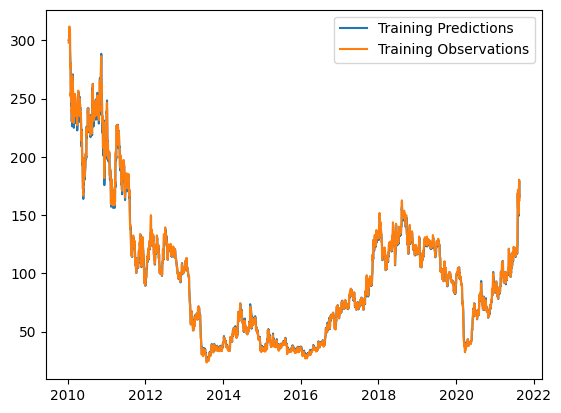

In [47]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

12/12 [==============================] - 0s 2ms/step


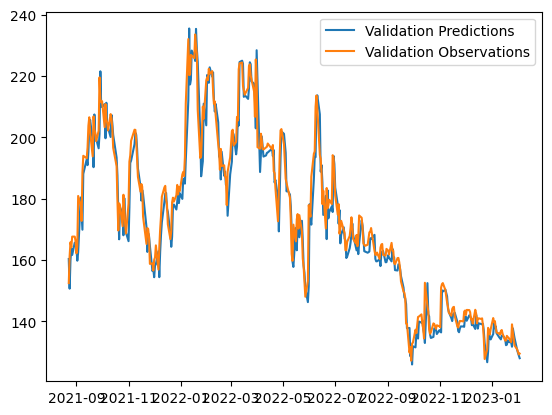

In [48]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

12/12 [==============================] - 0s 3ms/step


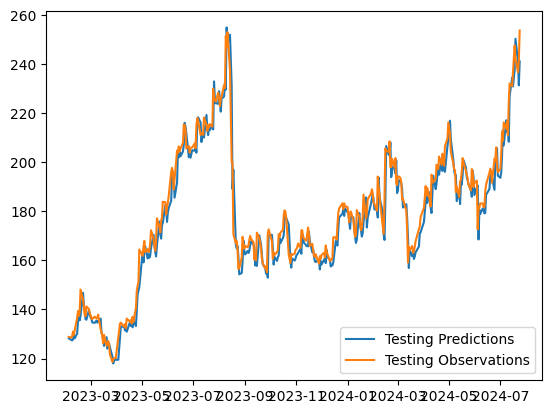

In [49]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

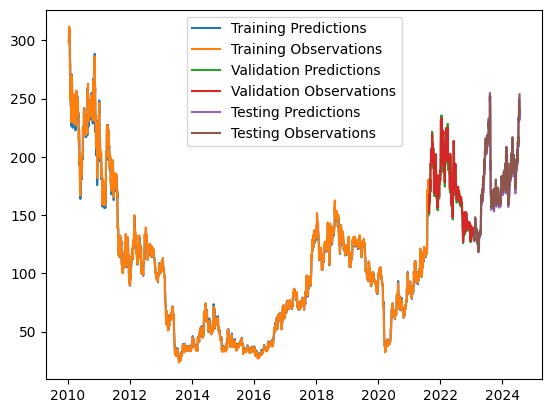

In [50]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:

  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)

  last_window = np.array(list(last_window.flatten()) + [next_prediction[0]])[1:]
  last_window = last_window[..., None]

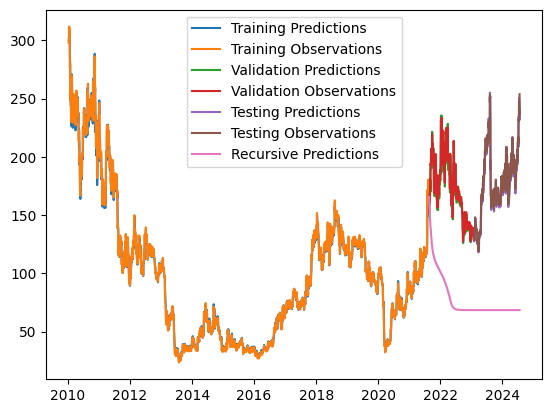

In [75]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [77]:
# Predictions for just the next day post training
print(len(val_predictions)+len(test_predictions), len(recursive_predictions))
print(y_val[0], recursive_predictions[0])

725 725
152.45 [165.78482]
